<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter2/2_3_Pyro%E3%81%AE%E6%A6%82%E8%A6%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
!pip install japanize-matplotlib
#!pip install pyro-ppl==1.7.0
!pip install pyro-ppl

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set_context('talk', font_scale=0.8)
import japanize_matplotlib

In [ ]:
import torch
from torch.distributions import constraints

import pyro

# 観測データ
y = torch.tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=torch.float)

In [ ]:
# モデルの定義
def model(y):
    # 事前分布のパラメータ
    alpha = torch.tensor(1.0)
    beta = torch.tensor(1.0)
    
    # 推論対象とするパラメータの事前分布
    theta = pyro.sample("theta", pyro.distributions.Beta(alpha, beta))
    
    # 観測データの数だけ生成
    with pyro.plate("sample", len(y)):
        # 尤度関数
        pyro.sample("obs", pyro.distributions.Bernoulli(theta), obs=y)

In [ ]:
# 近似分布の定義
def guide(y):
    # 最適化する変分パラメータ（正に制約）
    alpha_q = pyro.param("alpha_q", torch.tensor(5.0),
                      constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(5.0),
                         constraint=constraints.positive)
    
    # 近似分布にベータ分布を仮定
    pred_p = pyro.sample("theta", pyro.distributions.Beta(alpha_q, beta_q))
    return pred_p

In [ ]:
# グローバル変数として格納されているパラメータを削除
pyro.clear_param_store()
pyro.set_rng_seed(1)

# optimizerの設定
optimizer = pyro.optim.Adam({"lr": 0.0005})

# SVIの設定（ELBO計算に使う近似分布からのサンプル数を30に設定）
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO(num_particles=30))

# 最適化ループ
loss_list = []
for step in range(1000):
    loss = svi.step(y)
    loss_list.append(loss)

Text(0, 0.5, 'Loss')

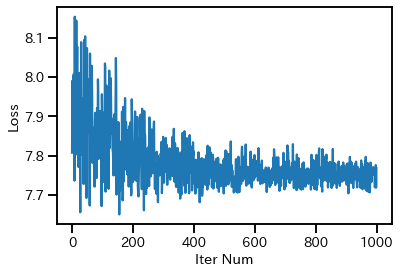

In [ ]:
plt.plot(loss_list)
plt.xlabel('Iter Num')
plt.ylabel('Loss')

In [ ]:
# グローバル管理されているパラメータを確認
for para_name in pyro.get_param_store():
    print(para_name)

alpha_q
beta_q


In [ ]:
# 近似分布の平均と標準偏差
alpha_q = pyro.param('alpha_q').detach().numpy()
beta_q = pyro.param('beta_q').detach().numpy()
variational_posterior = stats.beta(alpha_q, beta_q)
print('variational posterior mean: {:.3f}'.format(variational_posterior.mean()))
print('variational posterior std: {:.3f}'.format(variational_posterior.std()))

# 真の事後分布の平均と標準偏差
alpha_t = 1 + torch.sum(y)
beta_t = 1 + 10 - torch.sum(y)
true_posterior = stats.beta(alpha_t, beta_t)
print('true posterior mean: {:.3f}'.format(true_posterior.mean()))
print('true posterior std: {:.3f}'.format(true_posterior.std()))

variational posterior mean: 0.581
variational posterior std: 0.146
true posterior mean: 0.583
true posterior std: 0.137


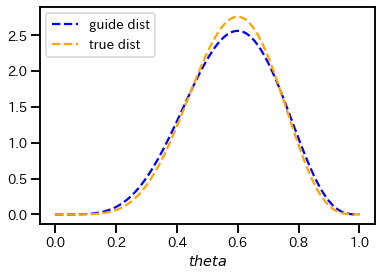

In [ ]:
x_lin = np.linspace(0.0, 1.0, 100)
fig, ax = plt.subplots(figsize=(6, 4))
# 近似分布
ax.plot(x_lin, variational_posterior.pdf(x_lin), ls='--', color='blue', label='guide dist')
# 真の事後分布
ax.plot(x_lin, true_posterior.pdf(x_lin), ls='--', color='orange', label='true dist')
ax.legend()
ax.set_xlabel('$theta$');

In [ ]:
%load_ext watermark
%watermark --iversions

pyro               : 1.8.1
numpy              : 1.21.6
IPython            : 5.5.0
pandas             : 1.3.5
matplotlib         : 3.2.2
arviz              : 0.12.1
torch              : 1.11.0+cu113
japanize_matplotlib: 1.1.3
scipy              : 1.4.1
seaborn            : 0.11.2

